<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [2]:
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers openpyxl datasets langchain-community ragatouille umap-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

ImportError: cannot import name 'AdamW' from 'transformers' (C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\__init__.py)

## Загрузка данных (4 балла)

In [10]:

data = pd.read_csv('file.csv')

In [11]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [12]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [13]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

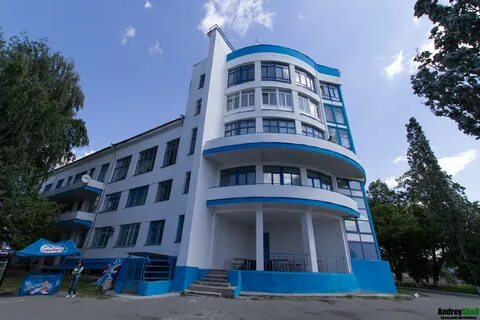

arafed building with a blue and white exterior and a blue fence


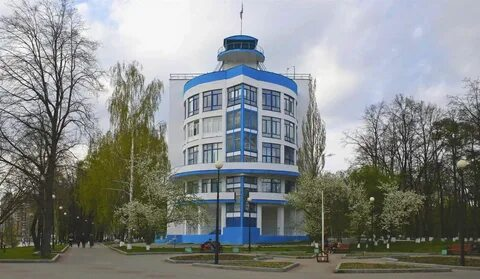

there is a blue and white building with a clock on top


In [14]:
def display_image(data):
    image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
    display(image)
    


for i in range(1, 3):
 
    display_image(data['image'].tolist()[i]), print(data.iloc[i]['en_txt'])

In [15]:
from ipywidgets import interact, IntSlider
from IPython.display import display
@interact(
    i=IntSlider(
        min=0,                     # Минимальный индекс
        max=len(data)-1,            # Максимальный индекс
        step=1,                     # Шаг
        value=539,                  # Начальное значение (как в вашем примере)
        description="Номер записи", # Подпись ползунка
        continuous_update=False     # Обновлять только при отпускании ползунка
    )
)
def show_image_and_text(i):
    # Отображаем изображение
    display_image(data['image'].iloc[i])
    
    # Выводим текст
    print(f"Текст (en_txt):\n{data['en_txt'].iloc[i]}")
    print("-" * 50)  # Разделитель

interactive(children=(IntSlider(value=539, continuous_update=False, description='Номер записи', max=14633), Ou…

 car - явно лишнинее описание, можно смело удалять такие айтемы (100 -110) 
 a close up of a poster
 boy sitting in front of a mirror taking a picture of himself
  highway
  traffic
  screenshot
   website
  a picture of a man in a suit and tie with a microscope
  the word 4k on it
  man
  men
  girl
  fan
  close up
  picture

  ['poster','boy','traffic','screenshot','website','microscope','4k','man','men','fan','girl']
 11921
 3778

In [ ]:
#arafed apartment building with a lot of windows on a street

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

## Сделаем предварительный анализ датасета 

In [16]:
print(data.shape)

(14634, 9)


In [ ]:
len(data['Name'].unique())

387

In [ ]:
data['City'].unique()

array(['Екатеринбург', 'Нижний Новгород', 'Владимир', 'Ярославль'],
      dtype=object)

In [ ]:
data['Name'].unique()

array(['Динамо', '№32 Дом обороны', 'Дом обороны',
       '№28 Здание городской электростанции «Луч»',
       '№27 Дом Г.Н. Скрябина', 'Литературная жизнь Урала XX века',
       'Дом-музей Бажова', 'Театр кукол', 'Харитоновский сад',
       'Храм в честь Вознесения Господня', 'Суворовское училище',
       'Свято-Троицкий Кафедральный собор',
       'Дом-музей Д. Н. Мамина-Сибиряка',
       'Художественный Музей Эрнста Неизвестного', 'Серго Орджоникидзе',
       'Н. И. Кузнецову', 'Успенский собор на ВИЗе', 'Царский мост',
       'Дом печати (Екатеринбург)', 'Музей изобразительных искусств',
       'Александро-Невский собор', 'Здание бывшей гостиницы "Мадрид"',
       'Екатеринбургский музей изобразительных искусств',
       'Уральский государственный медицинский университет',
       'Центральный стадион', 'Уральская государственная консерватория',
       '№18 Фотографический музей «Дом Метенкова»',
       'Преображенская церковь на Уктусе',
       'Уральский геологический музей', 'Дом 

Всего 387 уникалиных названий 

In [ ]:
city_counts = data['City'].value_counts()
city_counts

City
Ярославль          4372
Владимир           3511
Нижний Новгород    3469
Екатеринбург       3282
Name: count, dtype: int64

In [ ]:
len(data[data['Name']=='Динамо'])

41

## Борьба с выбросами 

In [17]:
all_text = ' '.join(data['en_txt'].astype(str))

In [18]:
all_text

"there are two people that are standing on a track in a stadium arafed building with a blue and white exterior and a blue fence there is a blue and white building with a clock on top there is a blue and white building with a clock on top there is a boat that is in the water near a building there is a building with a clock tower in the middle of a flower garden aerial view of a city with a soccer field and a large orange dome a view of a building with a clock tower on top of it arafed building with a blue and white sign on it arafed building with a blue and white sign on the side of it there is a building with a blue and white design on it arafed view of a city with a large building and a large dome aerial view of a city with a soccer field and a stadium aerial view of a soccer field and a river in a city a view of a building with a tower in the middle of a snowy area arafed building with a blue and white design on the front aerial view of a soccer field in a city with a river in the fo

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Настройка анализатора для n-грамм (биграммы, триграммы)
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform([all_text])
tfidf_matrix

<1x1824 sparse matrix of type '<class 'numpy.float64'>'
	with 1824 stored elements in Compressed Sparse Row format>

вывод: если на изображении попадается машина - то 80% текста описания машин или машины

если человек - тоже удаляем

если скриншот с сайта - тоже удаляем 


In [20]:
print("Уникальные термины:", vectorizer.get_feature_names_out())

Уникальные термины: ['1000' '100th' '123' ... 'zoo' 'прррмомоннннннннннн' 'сралнннннн']


In [21]:
features = np.array(vectorizer.get_feature_names_out())

scores = tfidf_matrix.mean(axis=0).A1
features = list(vectorizer.get_feature_names_out())
scores = list(tfidf_matrix.mean(axis=0).A1)


In [22]:

scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
features = vectorizer.get_feature_names_out()

sorted_indices = scores.argsort()
sorted_features = features[sorted_indices]
sorted_scores = scores[sorted_indices]

# Выбираем N самых редких терминов
N = 400
rare_terms = sorted_features[:N]
rare_scores = sorted_scores[:N]

print(f"Топ-{N} редких паттернов с наименьшими TF-IDF scores:")
for term, score in zip(rare_terms, rare_scores):
    print(f"{term}: {score}")
    if term == 'blue':
        print("Есть машина!") 

Топ-400 редких паттернов с наименьшими TF-IDF scores:
сралнннннн: 4.1394482126762366e-05
disco: 4.1394482126762366e-05
organization: 4.1394482126762366e-05
operating: 4.1394482126762366e-05
operate: 4.1394482126762366e-05
do: 4.1394482126762366e-05
opera: 4.1394482126762366e-05
omi: 4.1394482126762366e-05
doctor: 4.1394482126762366e-05
disc: 4.1394482126762366e-05
oltapiya: 4.1394482126762366e-05
officers: 4.1394482126762366e-05
ocean: 4.1394482126762366e-05
doh: 4.1394482126762366e-05
occinik: 4.1394482126762366e-05
occibik: 4.1394482126762366e-05
obel: 4.1394482126762366e-05
nympke: 4.1394482126762366e-05
domed: 4.1394482126762366e-05
document: 4.1394482126762366e-05
numbers: 4.1394482126762366e-05
ottohofen: 4.1394482126762366e-05
dinosaur: 4.1394482126762366e-05
pelicans: 4.1394482126762366e-05
peanut: 4.1394482126762366e-05
paws: 4.1394482126762366e-05
paved: 4.1394482126762366e-05
pattern: 4.1394482126762366e-05
patriotic: 4.1394482126762366e-05
papana: 4.1394482126762366e-05
dem

In [23]:
import re
indices = []
list1 =   np.array(['poster','boy','traffic','screenshot','website','microscope','4k','man','men','fan','girl','alcohol','girls','women','woman','car','cars','room','dirt','children','group','people','child','factory','diagram','image','collage','boys','sheet','toy'])
#list1 = np.array([])
rare_terms = np.concatenate([rare_terms, list1])

# добавить в список мои иключения 
for index, row in data.iterrows():
    # Проверяем, содержит ли текст любое из стоп-слов
    if any(re.search(r'\b' + re.escape(word) + r'\b',row['en_txt'], re.IGNORECASE) for word in rare_terms):
        indices.append(index)

print("Индексы строк, содержащих стоп-слова:", indices)

len(indices)


Индексы строк, содержащих стоп-слова: [0, 19, 21, 23, 25, 27, 37, 39, 44, 45, 48, 55, 56, 57, 59, 60, 61, 64, 71, 73, 75, 79, 81, 82, 83, 85, 88, 92, 96, 98, 100, 101, 106, 108, 109, 110, 111, 113, 114, 117, 119, 120, 123, 125, 131, 137, 138, 139, 143, 144, 146, 148, 149, 150, 154, 158, 159, 162, 165, 171, 172, 177, 181, 182, 186, 191, 193, 195, 202, 206, 213, 214, 215, 218, 219, 220, 223, 224, 225, 226, 227, 229, 232, 233, 235, 236, 238, 241, 243, 256, 281, 283, 289, 293, 301, 310, 311, 316, 324, 338, 341, 343, 346, 347, 348, 349, 350, 352, 353, 354, 355, 358, 361, 363, 364, 365, 366, 379, 384, 387, 399, 402, 405, 409, 416, 417, 418, 422, 426, 428, 430, 431, 435, 436, 437, 438, 440, 446, 449, 451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 51

5000

In [24]:
data_cleaned = data.drop(indices).reset_index(drop=True)

In [ ]:
@interact(
    i=IntSlider(
        min=0,                     # Минимальный индекс
        max=len(data_cleaned)-1,            # Максимальный индекс
        step=1,                     # Шаг
        value=0,                  # Начальное значение (как в вашем примере)
        description="Номер записи", # Подпись ползунка
        continuous_update=False     # Обновлять только при отпускании ползунка
    )
)
def show_image_and_text(i):
    # Отображаем изображение
    display_image(data_cleaned['image'].iloc[i])
    
    # Выводим текст
    print(f"Текст (en_txt):\n{data_cleaned['en_txt'].iloc[i]}")
    print("-" * 50)  # Разделитель

interactive(children=(IntSlider(value=0, continuous_update=False, description='Номер записи', max=9633), Outpu…

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

Проверим, справился ли TF IDF

In [26]:
import random


In [27]:

unique_combinations = data_cleaned[['City', 'Name']].drop_duplicates()
samples_per_combination = max(1, 100 // len(unique_combinations))
stratified_samples = []

for _, row in unique_combinations.iterrows():
    city = row['City']
    place = row['Name']
    
    # Получаем все строки с данной комбинацией
    subset = data_cleaned[(data_cleaned['City'] == city) & 
                          (data_cleaned['Name'] == place)]
    #print(subset)
    # Если строк меньше, чем нужно образцов, берем все
    if len(subset) <= samples_per_combination:
        samples = subset
    else:
        # Иначе выбираем случайные образцы
        samples = subset.sample(n=samples_per_combination)
    
    stratified_samples.append(samples)

# Объединяем все выбранные образцы
final_samples = pd.concat(stratified_samples)

# Сбрасываем индексы
final_samples = final_samples.reset_index(drop=True)

In [28]:
final_samples = final_samples.drop('Unnamed: 0', axis=1)

In [143]:
final_samples 

,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a blue...
1,№32 Дом обороны,Q55209768,Екатеринбург,60.601315,56.834167,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,aerial view of a roundabout with a fountain in...
2,Дом обороны,Q55209768,Екатеринбург,60.602409,56.835133,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,a black and white photo of a model of a building
3,№28 Здание городской электростанции «Луч»,Q55154121,Екатеринбург,60.607430,56.833691,здание и достопримечательность в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a tall chimney in the mid...
4,№27 Дом Г.Н. Скрябина,Q55232375,Екатеринбург,60.607075,56.834225,Дом Е.Д. Скрябиной,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large building with a clock on the ...
...,...,...,...,...,...,...,...,...
381,Ярославский камерный театр,Q4538885,Ярославль,39.881100,57.629101,Ярославский камерный театр,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a building with a lot of windows on t...
382,Ярославский музей-заповедник,Q4538889,Ярославль,39.890030,57.620876,Ярославский музей-заповедник,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,aerial view of a city with a church and a train
383,Ярославский филиал Военно-космической академии...,Q4538913,Ярославль,39.877613,57.607079,высшее военное училище в России,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed military band performing in front of a ...
384,Ярославский художественный музей (Губернаторск...,Q3329597,Ярославль,39.897274,57.628376,художественный музей в Ярославле,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed view of a large yellow building with a ...


In [ ]:
from langchain_core.documents import Document
documents = []
for idx, row in final_samples.iterrows():
    content = f"""Название: {row['Name']}
Город: {row['City']}
Координаты: Широта {row['Lat']}, Долгота {row['Lon']}
WikiData ID: {row['WikiData']}
Описание: {row['description']}
Описание изображения: {row['en_txt']}
"""
    metadata = {
        "name": row['Name'],
        "city": row['City'],
        "wikidata_id": row['WikiData'],
        "coordinates": f"{row['Lat']}, {row['Lon']}",
    }
    
    # Создаем документ
    doc = Document(page_content=content, metadata=metadata)
    documents.append(doc)


In [177]:
documents

[Document(metadata={'name': 'Динамо', 'city': 'Екатеринбург', 'wikidata_id': 'Q37996725', 'coordinates': '56.845398, 60.600349'}, page_content='Название: Динамо\nГород: Екатеринбург\nКоординаты: Широта 56.845398, Долгота 60.600349\nWikiData ID: Q37996725\nОписание: спорткомплекс в Екатеринбурге\nОписание изображения: there is a blue and white building with a blue roof\n'),
 Document(metadata={'name': '№32 Дом обороны', 'city': 'Екатеринбург', 'wikidata_id': 'Q55209768', 'coordinates': '56.834167, 60.601315'}, page_content='Название: №32 Дом обороны\nГород: Екатеринбург\nКоординаты: Широта 56.834167, Долгота 60.601315\nWikiData ID: Q55209768\nОписание: здание в Екатеринбурге\nОписание изображения: aerial view of a roundabout with a fountain in the middle of a city\n'),
 Document(metadata={'name': 'Дом обороны', 'city': 'Екатеринбург', 'wikidata_id': 'Q55209768', 'coordinates': '56.835133, 60.602409'}, page_content='Название: Дом обороны\nГород: Екатеринбург\nКоординаты: Широта 56.835133

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    separator="\n"  
)

chunks = text_splitter.split_documents(documents)

In [179]:

# Использование локальной модели для эмбеддингов
from langchain.embeddings import HuggingFaceEmbeddings


# Используем SentenceTransformers напрямую
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)


vector_db = FAISS.from_documents(
    documents=chunks, 
    embedding=embeddings, distance_strategy=DistanceStrategy.COSINE
)


Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

Ragtune не работает, нужна альтернатива. Базовое ранжирование по косинусному сходству (уже реализовано в FAISS)

In [91]:
def retrieve_docs(query, k=5):
    docs = vector_db.similarity_search(query, k=k)
    return docs

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

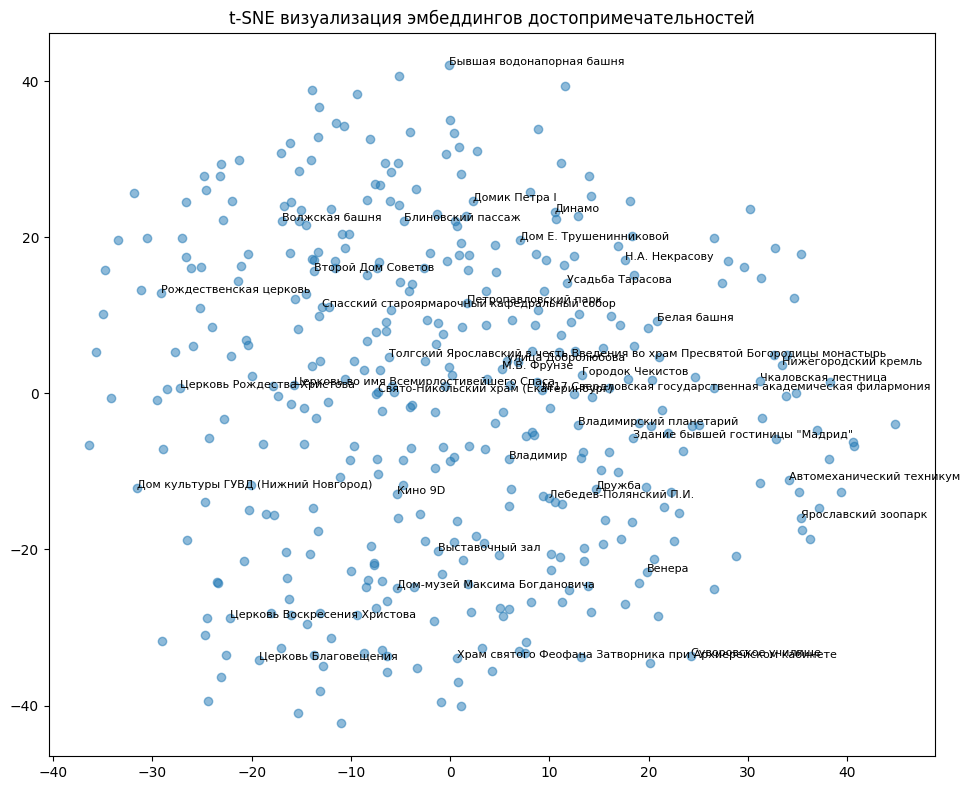

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


all_docs = documents
all_embeddings = [embeddings.embed_query(doc.page_content) for doc in all_docs]
all_embeddings_array = np.array(all_embeddings)


tsne = TSNE(n_components=3, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings_array)

# Визуализируем
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)


for i, doc in enumerate(all_docs):
    if i % 10 == 0: 
        plt.annotate(doc.metadata['name'], 
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=8)

plt.title('t-SNE визуализация эмбеддингов достопримечательностей')
plt.tight_layout()
plt.show()

Umap - более продвинутая вещь 

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


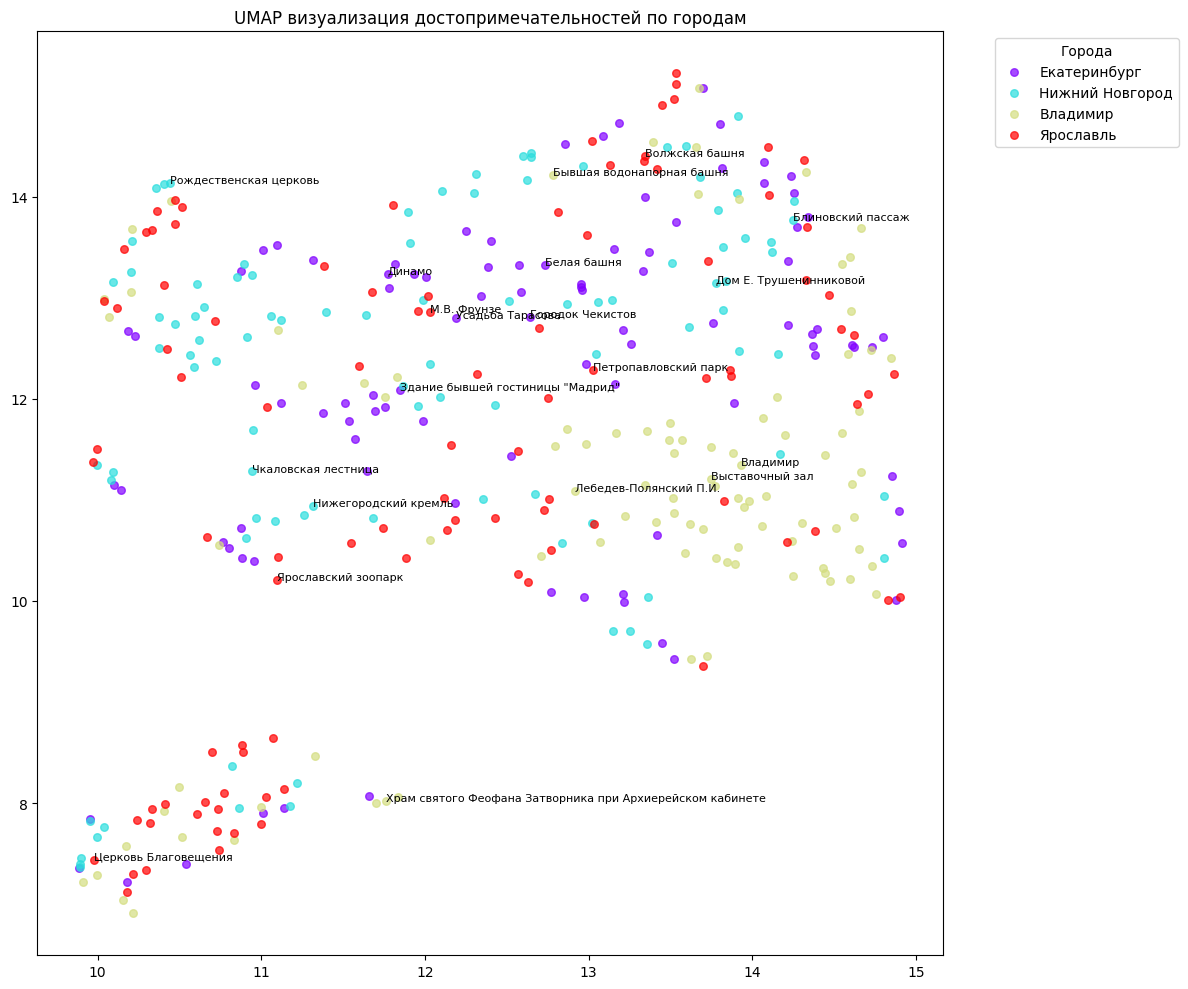

In [58]:
import umap
import pandas as pd


reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(all_embeddings_array)

# Создаем DataFrame для более удобной визуализации
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'name': [doc.metadata['name'] for doc in all_docs],
    'city': [doc.metadata['city'] for doc in all_docs]
})

# Визуализируем с цветовой кодировкой по городам
plt.figure(figsize=(12, 10))

# Получаем список уникальных городов
cities = viz_df['city'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(cities)))

for i, city in enumerate(cities):
    city_data = viz_df[viz_df['city'] == city]
    plt.scatter(city_data['x'], city_data['y'], 
                label=city, color=colors[i], alpha=0.7, s=30)
for i, doc in enumerate(all_docs):
    if i % 20== 0: 
        plt.annotate(doc.metadata['name'], 
                    (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=8)

plt.legend(title='Города', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('UMAP визуализация достопримечательностей по городам')
plt.tight_layout()
plt.show()

ValueError: perplexity must be less than n_samples

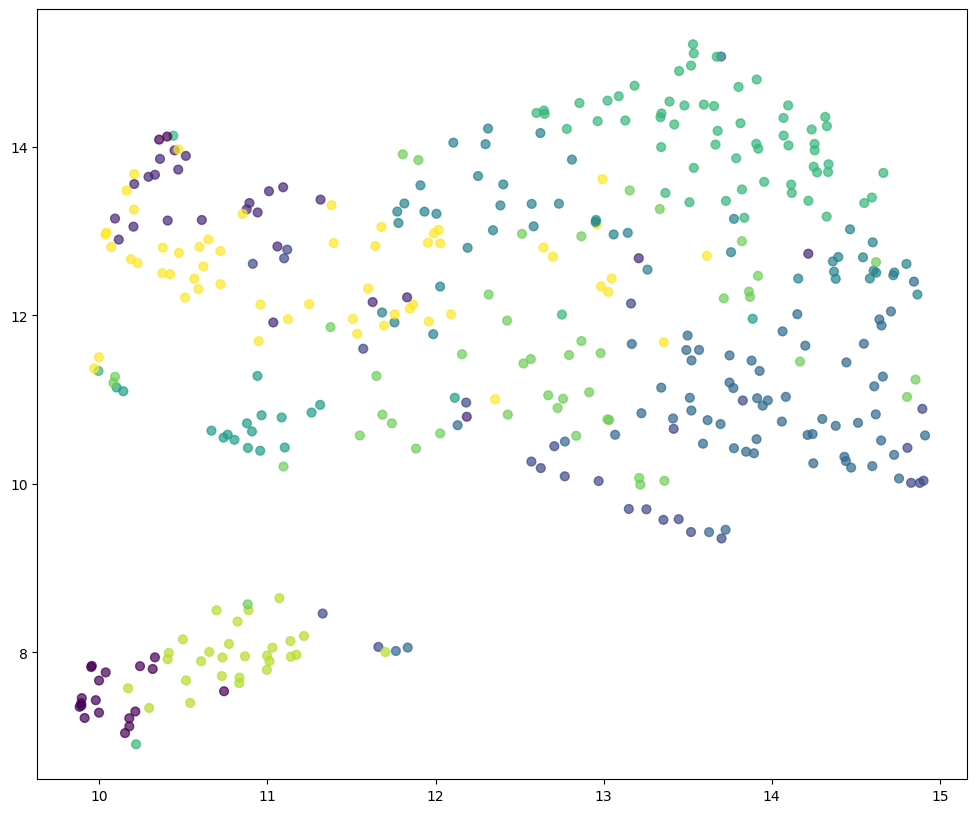

In [60]:
from sklearn.cluster import KMeans

# Кластеризация эмбеддингов
n_clusters = 10  # Подберите оптимальное количество кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(all_embeddings_array)

# Добавляем информацию о кластерах в DataFrame
viz_df['cluster'] = clusters

# Визуализируем с цветовой кодировкой по кластерам
plt.figure(figsize=(12, 10))
scatter = plt.scatter(viz_df['x'], viz_df['y'], 
                      c=viz_df['cluster'], cmap='viridis', 
                      alpha=0.7, s=40)

# Добавляем центры кластеров
centers = kmeans.cluster_centers_
centers_2d = TSNE(n_components=2, random_state=42).fit_transform(centers)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', 
            marker='X', s=100, label='Центры кластеров')

plt.colorbar(scatter, label='Кластер')
plt.title('Кластеризация достопримечательностей по эмбеддингам')
plt.legend()
plt.tight_layout()
plt.savefig('attraction_clusters.png', dpi=300)
plt.show()

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

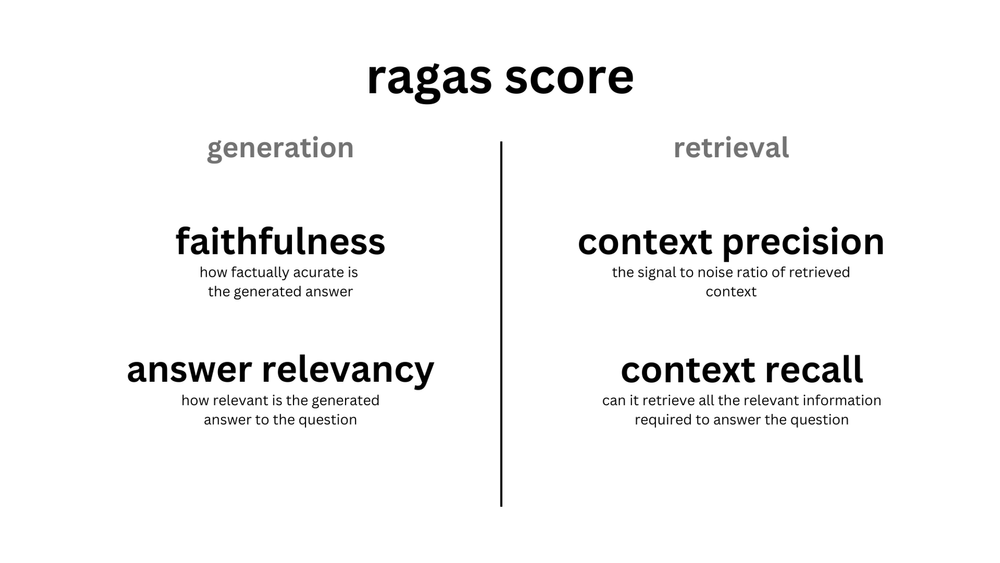

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [ ]:


def data_preprocess(df, sample_size=100, seed=42):

    random.seed(seed)
    np.random.seed(seed)
    
    # Выбор случайных сэмплов
    if len(df) > sample_size:
        df_sampled = df.sample(n=sample_size, random_state=seed)
    else:
        df_sampled = df.copy()
    
    # Создание списков для хранения сгенерированных вопросов и ответов
    questions = []
    answers = []
    ground_truths = []
    contexts = []
    
    # Шаблоны вопросов для различных типов информации
    location_questions = [
        "Где находится {name}?",
        "В каком городе расположен объект {name}?",
        "Какие географические координаты у {name}?"
    ]
    
    description_questions = [
        "Что представляет собой {name}?",
        "Опишите объект {name}.",
        "Что такое {name}?"
    ]
    
    image_questions = [
        "Что изображено на фотографии объекта {name}?",
        "Опишите изображение объекта {name}.",
        "Что можно увидеть на фотографии {name}?"
    ]
    
    # Для каждой строки генерируем вопросы и ответы
    for _, row in tqdm(df_sampled.iterrows(), total=len(df_sampled)):
        # Извлекаем данные
        name = row['Name']
        city = row['City']
        lat = row['Lat']
        lon = row['Lon']
        description = row['description']
        en_txt = row['en_txt']
        
        # Создаем контекст (объединение всей информации об объекте)
        context = f"{name} - {description}, расположен в городе {city}, координаты: {lat}, {lon}. Описание изображения: {en_txt}"
        
        # Выбираем тип вопроса случайным образом
        question_type = random.choice(['location', 'description', 'image'])
        
        if question_type == 'location':
            # Генерация вопроса о местоположении
            question = random.choice(location_questions).format(name=name)
            answer = f"{name} находится в городе {city}, по координатам: широта {lat}, долгота {lon}."
            ground_truth = f"{name} расположен в {city}."
            
        elif question_type == 'description':
            # Генерация вопроса об описании объекта
            question = random.choice(description_questions).format(name=name)
            answer = f"{name} - это {description}."
            ground_truth = f"{description}"
            
        else:  # image
            # Генерация вопроса об изображении
            question = random.choice(image_questions).format(name=name)
            answer = f"На изображении объекта {name}: {en_txt}"
            ground_truth = f"{en_txt}"
        
        # Добавляем сгенерированные данные в списки
        questions.append(question)
        answers.append(answer)
        ground_truths.append(ground_truth)
        contexts.append(context)
    
    # Создаем новый датафрейм с сгенерированными вопросами и ответами
    result_df = pd.DataFrame({
        'question': questions,
        'answer': answers,
        'ground_truths': ground_truths,
        'contexts': contexts
    })
    
    return result_df

In [63]:
data_rags = data_preprocess(final_samples)

  0%|          | 0/100 [00:00<?, ?it/s]

In [254]:
data_rags.head(30)

,question,answer,ground_truths,contexts
0,Что изображено на фотографии объекта Памятник ...,На изображении объекта Памятник Леониду Никола...,there is a black monument with a clock on it i...,Памятник Леониду Николаевичу Трефолеву - Памят...
1,Какие географические координаты у Демидовский ...,Демидовский столп (Ярославль) находится в горо...,Демидовский столп (Ярославль) расположен в Яро...,Демидовский столп (Ярославль) - Демидовский ст...
2,Что представляет собой Свято-Никольский храм (...,Свято-Никольский храм (Екатеринбург) - это пра...,православный храм в Екатеринбурге,Свято-Никольский храм (Екатеринбург) - правосл...
3,Где находится Фавор?,"Фавор находится в городе Владимир, по координа...",Фавор расположен в Владимир.,"Фавор - nan, расположен в городе Владимир, коо..."
4,Что изображено на фотографии объекта Спасский ...,На изображении объекта Спасский староярмарочны...,arafed white building with a black dome and a ...,Спасский староярмарочный кафедральный собор - ...
5,Что можно увидеть на фотографии Власьевская (З...,На изображении объекта Власьевская (Знаменская...,there is a large white building with a clock t...,Власьевская (Знаменская) башня - Крепостная ба...
6,Что изображено на фотографии объекта Уральский...,На изображении объекта Уральский государственн...,arafed view of a building with a large front p...,Уральский государственный технический универси...
7,Опишите изображение объекта Нижегородская собо...,На изображении объекта Нижегородская соборная ...,arafed building with a dome and a steeple on top,Нижегородская соборная мечеть - Нижегородская ...
8,Где находится Исторический центр Ярославля?,Исторический центр Ярославля находится в город...,Исторический центр Ярославля расположен в Ярос...,Исторический центр Ярославля - Исторический це...
9,Где находится Малышеву?,"Малышеву находится в городе Екатеринбург, по к...",Малышеву расположен в Екатеринбург.,"Малышеву - Памятник в Екатеринбурге, расположе..."


In [64]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def answer_relevancy(df, model_name='all-MiniLM-L6-v2'):

    model = SentenceTransformer(model_name)
    
    # Создание копии датафрейма для результатов
    result_df = df.copy()
    
    # Получение эмбеддингов для вопросов и ответов
    questions_embeddings = model.encode(df['question'].tolist())
    answers_embeddings = model.encode(df['answer'].tolist())
    
    # Вычисление косинусного сходства между вопросами и ответами
    relevancy_scores = []
    
    for i in range(len(df)):
        question_emb = questions_embeddings[i].reshape(1, -1)
        answer_emb = answers_embeddings[i].reshape(1, -1)
        
        # Вычисление косинусного сходства
        similarity = cosine_similarity(question_emb, answer_emb)[0][0]
        relevancy_scores.append(similarity)
    
    # Добавление результатов в датафрейм
    result_df['relevancy_score'] = relevancy_scores
    
    # Вычисление средней метрики по всему датасету
    avg_relevancy = np.mean(relevancy_scores)
    print(f"Средняя релевантность ответов: {avg_relevancy:.4f}")
    
    return result_df

# Протестируйте ваш RAG (3 балла)

Выбор ллм модели

In [248]:
from transformers import pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
llm = pipeline("text-generation", model="sberbank-ai/mGPT")

langchain_llm = HuggingFacePipeline(pipeline=llm,model_kwargs={
            "temperature": 0.3,
            "max_length": 512,
            "do_sample": False,
            "top_p": 0.9
        })
    


Device set to use cpu


In [277]:
def answer_with_rag(question, knowledge_db):
    # Инициализация модели
   
    # Создание промпта
    prompt_template = """Ответь на вопрос на основе контекста:
    Контекст: {context}
    
    Вопрос: {question}
    
    Ответ:"""
    
    PROMPT = PromptTemplate(
        template=prompt_template, 
        input_variables=["context", "question"]
    )
    print("=> 🔍 Ищем релевантные документы...")
    # Настройка цепочки RAG
    qa_chain = RetrievalQA.from_chain_type(
        llm=langchain_llm,
        chain_type="stuff",
        retriever=knowledge_db.as_retriever(search_kwargs={"k": 2}),
        chain_type_kwargs={"prompt": PROMPT}
    )
    
    # Получение ответа
    result = qa_chain({"query": question})
    return result["result"]

# Пример использования (предполагается, что vector_db уже создана)


In [252]:
question = "Перечисли церкви Нижнего Новгорода и скажи навзание"
answer1 = answer_with_rag(question, vector_db)
print(answer1)

=> 🔍 Ищем релевантные документы...
Ответь на вопрос на основе контекста:
    Контекст: Название: Церковь во имя Святого Пророка Божия Илии
Город: Нижний Новгород
Координаты: Широта 56.328205, Долгота 43.993713
WikiData ID: Q59901
Описание: церковь в Нижнем Новгороде
Описание изображения: there is a large red building with a gold dome on top

Название: Церковь Рождества Иоана Предтечи
Город: Нижний Новгород
Координаты: Широта 56.329777, Долгота 43.998135
WikiData ID: Q2037203
Описание: Церковь Рождества Иоанна Предтечи на Торгу
Описание изображения: arafed view of a church with a steeple and a steeple on the top

Название: Церковь Александра Невского в Сормово
Город: Нижний Новгород
Координаты: Широта 56.357773, Долгота 43.868862
WikiData ID: Q16715547
Описание: Церковь Александра Невского в Сормово
Описание изображения: tall red building with a gold spire and a clock on top
    
    Вопрос: Перечисли церкви Нижнего Новгорода и скажи навзание
    
    Ответ: Церковь Александра Невского 

In [256]:
question = "Где находится чкаловская лестница?"
answer2 = answer_with_rag(question, vector_db)
print(answer2)

=> 🔍 Ищем релевантные документы...
Ответь на вопрос на основе контекста:
    Контекст: Название: Чкаловская лестница
Город: Нижний Новгород
Координаты: Широта 56.330479, Долгота 44.009453
WikiData ID: Q4516884
Описание: лестница на Волжском откосе в Нижнем Новгороде
Описание изображения: arafed view of a large building with a green lawn and a long staircase

Название: Чкаловская лестница 
Город: Нижний Новгород
Координаты: Широта 56.330471, Долгота 44.009426
WikiData ID: Q4516884
Описание: лестница на Волжском откосе в Нижнем Новгороде
Описание изображения: arafed view of a city at night with a circular bridge

Название: Лицей № 82
Город: Нижний Новгород
Координаты: Широта 56.349937, Долгота 43.864075
WikiData ID: Q4264363
Описание: Лицей № 82 "Школа баррикад"
Описание изображения: a close up of a street sign with a building in the background
    
    Вопрос: Где находится чкаловская лестница?
    
    Ответ: В Нижнем Новгороде

















In [286]:

langchain_llm = HuggingFacePipeline(pipeline=llm,model_kwargs={
            "temperature": 0.0,
            "max_length": 4000,
            "do_sample": False,
            "top_p": 0.99
        })

In [287]:
question = " церковь города Владимир"
answer3 = answer_with_rag(question, vector_db)
print(answer3)

=> 🔍 Ищем релевантные документы...
Ответь на вопрос на основе контекста:
    Контекст: Название: Церковь Софии Премудрости Божией в Савино
Город: Ярославль
Координаты: Широта 57.623425, Долгота 39.919182
WikiData ID: Q16715786
Описание: Церковь в Ярославле
Описание изображения: there is a large building with a clock tower in the middle of a city

Название: Троицкая церковь
Город: Владимир
Координаты: Широта 56.126453, Долгота 40.396076
WikiData ID: Q9187382
Описание: Троицкая церковь
Описание изображения: arafed view of a church with a clock tower and a clock tower
    
    Вопрос:  церковь города Владимир
    
    Ответ:  церковь города Владимир

Название: Церковь Рождества Богородицы в селе Княжево


В ходе работы был проведён предварительный анализ и очистка датасета с использованием TF-IDF, а также эмпирических наблюдений и экспериментов. Из-за значительных затрат времени на эти этапы было принято решение отказаться от конкатенации описаний, сочтя её нецелесообразной.

В качестве основной LLM-модели была выбрана sberbank-ai/mGPT — лёгкая модель, хорошо работающая на CPU. Были проведены эксперименты с параметрами генерации, включая температуру, однако модель, по-видимому, с трудом воспринимает подобный контекст, что отразилось на итоговом качестве ответов.

Результатами доволен не в полной мере, однако старался сделать максимум в рамках текущих ограничений. Буду рад получить обратную связь — пишите в Telegram: @imfrnd.
